In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Coca Cola

### dados historicos

In [8]:
data = yf.download('KO', start='2020-01-01', end='2025-01-01')
data = data[['Close','High','Low']].dropna()

[*********************100%***********************]  1 of 1 completed


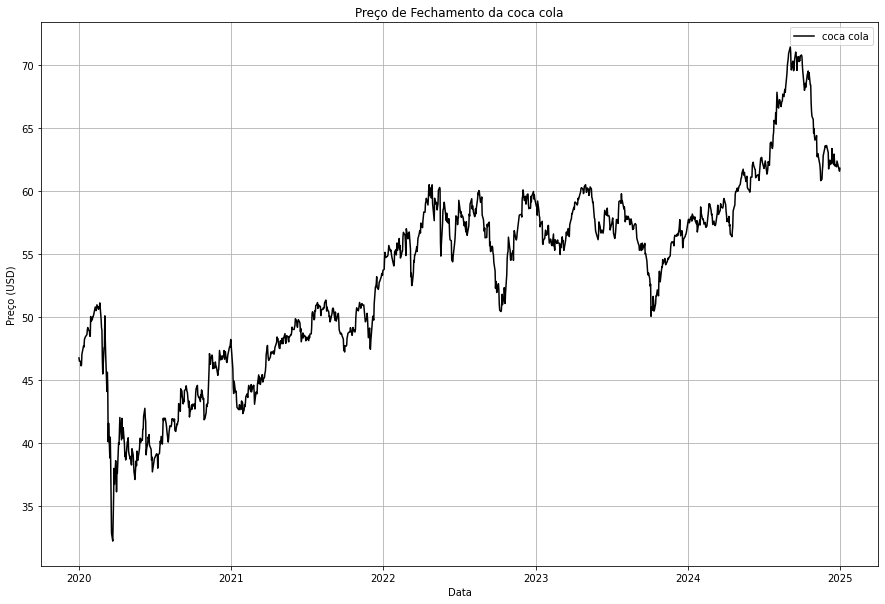

In [9]:
plt.figure(figsize=(15, 10)) 
plt.plot(data['Close'], label='coca cola', color='black', alpha=1)
plt.title('Preço de Fechamento da coca cola')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

Podemos perceber que a coca cola possui ativos com uma tendência de crescimento clara. Por isso, vamos utilizar a estratégia ADX (Average Directional Index).
## ADX (Average Directional Index) 

O ADX mede a força da tendência (mas não a direção). Sendo que +DI (força compradora) e -DI (força vendedora).
Quando ADX > 25 (tendência forte) ou +DI cruza acima de -DI, temos uma posição de Compra (entrada longa) e quando -DI cruza acima de +DI ou ADX cai abaixo de 20 (tendência fraca), temos uma posição de Venda (saída da posição)



In [10]:
def calculate_adx(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)

    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    plus_di = 100 * pd.Series(plus_dm, index=df.index).rolling(window=period).sum() / atr
    minus_di = 100 * pd.Series(minus_dm, index=df.index).rolling(window=period).sum() / atr
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)).replace([np.inf, -np.inf], 0) * 100
    adx = dx.rolling(window=period).mean().fillna(0)

    return adx

In [11]:
def backtest(df, adx_thresh=25, ema_period=10):
    if df.empty or df.shape[0] < 50:
        raise ValueError("Dados insuficientes para backtest.")

    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
    df['ADX'] = calculate_adx(df)

    # Sinal de compra/venda
    df['Signal'] = 0
    df.loc[(df['Close'] > df['EMA']) & (df['ADX'] > adx_thresh), 'Signal'] = 1
    df.loc[(df['Close'] < df['EMA']) & (df['ADX'] > adx_thresh), 'Signal'] = -1

    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy'] = df['Signal'].shift(1) * df['Return']
    df['Buy & Hold'] = df['Return']

    # Retorno acumulado
    result = df[['Strategy', 'Buy & Hold']].cumsum().apply(np.exp)
    return result

In [14]:
data.columns = data.columns.droplevel(1)
result = backtest(data)

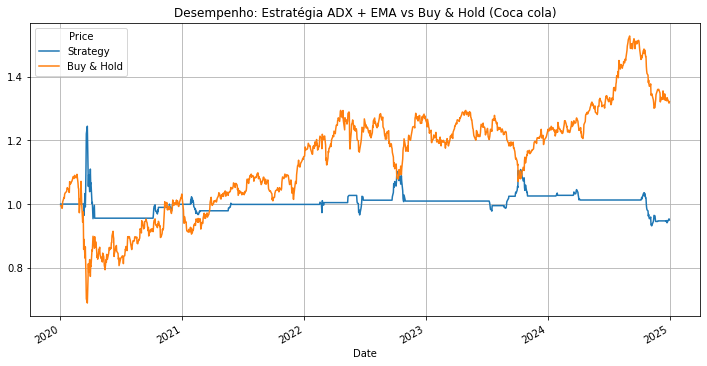

In [22]:
result.plot(title='Desempenho: Estratégia ADX + EMA vs Buy & Hold (Coca cola)', figsize=(12,6))
plt.grid()
plt.show()

## Teste de sensibilidade

c:\Users\sergi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


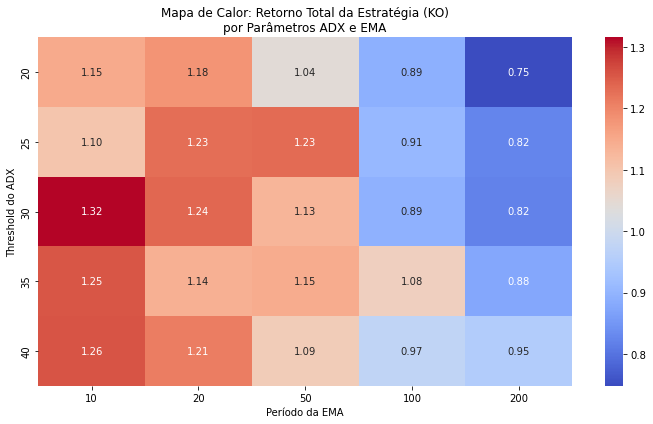

In [21]:
import seaborn as sns

adx_vals = [20, 25, 30, 35, 40]
ema_vals = [10, 20, 50, 100, 200]

results = []

for adx in adx_vals:
    for ema in ema_vals:
        try:
            result = backtest(data, adx_thresh=adx, ema_period=ema)
            final_return = result['Strategy'].iloc[-1]
            results.append((adx, ema, final_return))
            #print(f"ADX={adx} | EMA={ema} => Retorno final: {final_return:.2f}")
        except Exception as e:
            print(f"Erro com ADX={adx} e EMA={ema}: {e}")

# Organizar resultados em DataFrame
df_results = pd.DataFrame(results, columns=['ADX', 'EMA', 'TotalReturn'])

# Criar pivot para heatmap
heatmap_data = df_results.pivot(index='ADX', columns='EMA', values='TotalReturn')

# Plotar o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de Calor: Retorno Total da Estratégia (KO)\npor Parâmetros ADX e EMA")
plt.xlabel("Período da EMA")
plt.ylabel("Threshold do ADX")
plt.tight_layout()
plt.show()

## Adicionando complexibilidade

Adição de condição de cruzamento de duas EMAs (EMA curta vs EMA longa), confirmação por RSI (evitar compras em sobrecompra ou vendas em sobrevenda) e Stop Loss e Take Profit fixos (simples, em % do preço de entrada).

In [25]:
from ta.momentum import RSIIndicator

def backtest_complex(df, adx_thresh=25, ema_short=10, ema_long=50, rsi_period=14, stop_loss=0.05, take_profit=0.10):
    df = df.copy()
    
    # Indicadores
    df['EMA_short'] = df['Close'].ewm(span=ema_short, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=ema_long, adjust=False).mean()
    df['ADX'] = calculate_adx(df)
    df['RSI'] = RSIIndicator(close=df['Close'], window=rsi_period).rsi()
    
    df['Position'] = 0

    position = 0  # 1 comprado, -1 vendido, 0 fora
    entry_price = 0

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]

        # Verificar stop ou take profit
        if position != 0 and entry_price != 0:
            change = (row['Close'] - entry_price) / entry_price
            if position == 1:
                if change <= -stop_loss or change >= take_profit:
                    position = 0
            elif position == -1:
                if -change <= -stop_loss or -change >= take_profit:
                    position = 0

        # Sinais de entrada
        if row['ADX'] > adx_thresh:
            if row['EMA_short'] > row['EMA_long'] and row['RSI'] < 70 and position == 0:
                position = 1
                entry_price = row['Close']
            elif row['EMA_short'] < row['EMA_long'] and row['RSI'] > 30 and position == 0:
                position = -1
                entry_price = row['Close']

        df.iloc[i, df.columns.get_loc('Position')] = position

    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy'] = df['Position'].shift(1) * df['Return']
    df['Buy & Hold'] = df['Return']
    df = df.dropna()

    result = df[['Strategy', 'Buy & Hold']].cumsum().apply(np.exp)
    return result

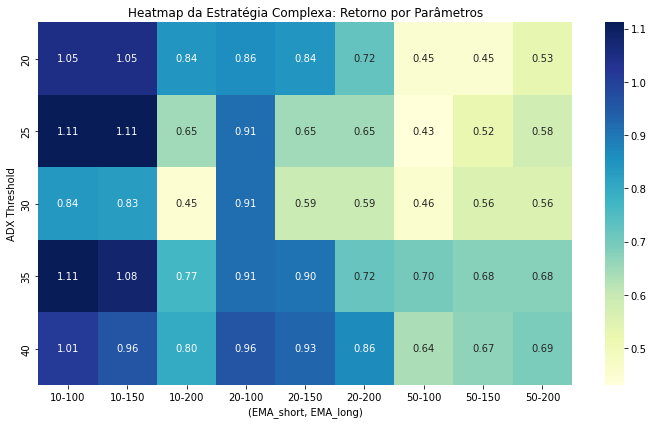

In [29]:
adx_vals = [20, 25, 30, 35, 40]

ema_short_vals = [10, 20,50]
ema_long_vals = [100,150,200]
results = []

for adx in adx_vals:
    for short in ema_short_vals:
        for long in ema_long_vals:
            if short >= long:
                continue  # Evitar EMA curta >= EMA longa

            try:
                result = backtest_complex(data, adx_thresh=adx, ema_short=short, ema_long=long)
                final_return = result['Strategy'].iloc[-1]
                results.append((adx, short, long, final_return))
                #print(f"ADX={adx} | EMA_short={short} | EMA_long={long} => Retorno: {final_return:.2f}")
            except Exception as e:
                print(f"Erro com ADX={adx}, short={short}, long={long}: {e}")

df_results = pd.DataFrame(results, columns=['ADX', 'EMA_short', 'EMA_long', 'TotalReturn'])
pivot = df_results.pivot_table(index='ADX', columns=['EMA_short', 'EMA_long'], values='TotalReturn')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap da Estratégia Complexa: Retorno por Parâmetros")
plt.xlabel("(EMA_short, EMA_long)")
plt.ylabel("ADX Threshold")
plt.tight_layout()
plt.show()
